In [29]:
import os 
import subprocess


emmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/repeated_locscale_run/using_model_map/pdb_5a63_model_map.mrc"
model_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/repeated_locscale_run/using_model_map/pdb_5a63_model_map.mrc"

output_dir = os.path.dirname(emmap_path)
map_format = os.path.join(output_dir, "pdb_5a63_MB_locscale_cycle_{}.mrc")
locscale_output_paths = {k : map_format.format(k) for k in range(0, 7) if os.path.exists(map_format.format(k))}


In [30]:
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps, calculate_phase_correlation_maps, calculate_amplitude_correlation_maps

fsc_curves = { k : calculate_fsc_maps(emmap_path, locscale_output_paths[k]) for k in locscale_output_paths.keys()}

In [31]:
from locscale.include.emmer.ndimage.fsc_util import calculate_phase_correlation_maps, calculate_amplitude_correlation_maps


phase_curves = { k : calculate_phase_correlation_maps(emmap_path, locscale_output_paths[k]) for k in locscale_output_paths.keys()}
amplitude_corr_curves = { k : calculate_amplitude_correlation_maps(emmap_path, locscale_output_paths[k]) for k in locscale_output_paths.keys()}

In [32]:
fsc_curves.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

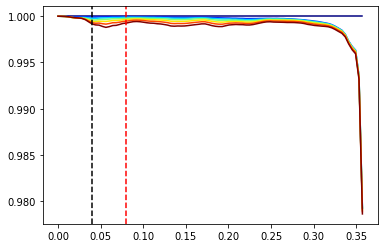

In [33]:
# plot the fsc curves 
from locscale.include.emmer.ndimage.map_utils import load_map 
from locscale.include.emmer.ndimage.profile_tools import frequency_array
import matplotlib.pyplot as plt
import numpy as np

# color the fsc curves based on the cycle number
colors = plt.cm.jet(np.linspace(0, 1, len(fsc_curves.keys())))
window_size = 25 #A
emmap, apix = load_map(emmap_path)

freq = frequency_array(fsc_curves[1], apix)

for cycle in fsc_curves.keys():
    plt.plot(freq, fsc_curves[cycle], color=colors[cycle], label=f"Cycle {cycle}")
plt.axvline(1/window_size, color="black", linestyle="--")
plt.axvline(1/(window_size/2), color="red", linestyle="--")
#plt.ylim(0, 1.1)


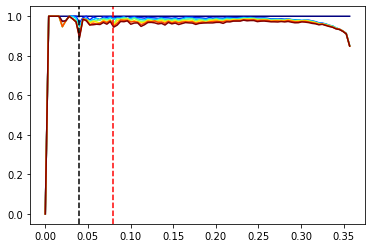

In [34]:
for cycle in phase_curves.keys():
    plt.plot(freq, phase_curves[cycle], color=colors[cycle], label=f"Cycle {cycle}")
#plt.ylim(0, 1.1)
# add a vertical line at 1/25 A^-1
plt.axvline(1/window_size, color="black", linestyle="--")
plt.axvline(1/(window_size/2), color="red", linestyle="--")

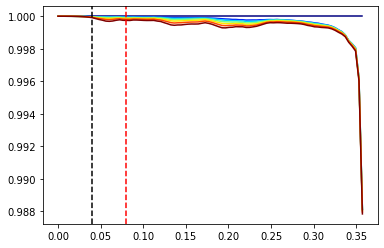

In [35]:
for cycle in amplitude_corr_curves.keys():
    plt.plot(freq, amplitude_corr_curves[cycle], color=colors[cycle], label=f"Cycle {cycle}")
#plt.ylim(0, 1.1)
plt.axvline(1/window_size, color="black", linestyle="--")
plt.axvline(1/(window_size/2), color="red", linestyle="--")


In [36]:
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile 
from locscale.include.emmer.ndimage.map_utils import load_map

def radial_profile_from_emmap_path(emmap_path):
    emmap, apix = load_map(emmap_path)
    return compute_radial_profile(emmap)

radial_profiles = {k : radial_profile_from_emmap_path(locscale_output_paths[k]) for k in locscale_output_paths.keys()}
   

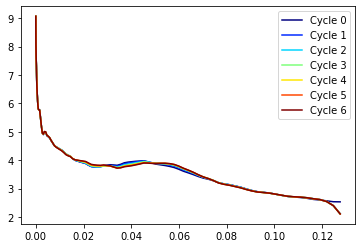

In [37]:
for cycle in fsc_curves.keys():
    plt.plot(freq**2, np.log(radial_profiles[cycle]), color=colors[cycle], label=f"Cycle {cycle}")

plt.legend()

In [38]:
def compute_radial_phase_profile(vol, center=[0,0,0], return_indices=False):
    '''
    Computes the radial profile of a given volume

    Parameters
    ----------
    vol : numpy.ndarray
        Input array
    center : list, optional
        DESCRIPTION. The default is [0,0,0].
    return_indices : bool, optional
        

    Returns
    -------
    radial_profile : numpy.ndarray (1D)
        Radial profile
        

    '''
    dim = vol.shape
    m = np.mod(vol.shape,2)
    # make compliant with both fftn and rfftn
    if center is None:
        ps = np.angle(np.fft.fftshift((np.fft.fftn(vol))))
        z, y, x = np.indices(ps.shape)
        center = tuple((a - 1) / 2.0 for a in ps.shape[::-1])
        radii = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
        radii = radii.astype(int)
    else:
        ps = np.angle( np.fft.rfftn(vol) )
        if not return_indices:
            x, y, z = np.indices(ps.shape)
            radii = np.sqrt(x**2 + y**2 + z**2)
            radii = radii.astype(int)
        else:
            [x, y, z] = np.mgrid[-dim[0]//2+m[0]:(dim[0]-1)//2+1, -dim[1]//2+m[1]:(dim[1]-1)//2+1, 0:dim[2]//2+1]
            x = np.fft.ifftshift(x)
            y = np.fft.ifftshift(y)
            radii = np.sqrt(x**2 + y**2 + z**2)
            radii = radii.astype(int)
    radial_profile = np.bincount(radii.ravel(), ps.ravel()) / np.bincount(radii.ravel())
    # exclude corner frequencies
    radial_profile = radial_profile[0:int(ps.shape[0]/2)]
    if not return_indices:
        return radial_profile
    else:
        return radial_profile, radii

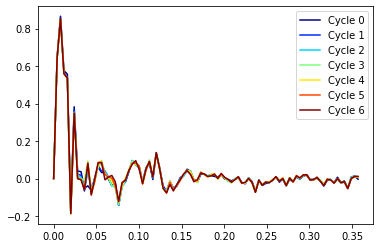

In [39]:
def compute_radial_phase_profile_from_emmap_path(emmap_path):
    emmap, apix = load_map(emmap_path)
    return compute_radial_phase_profile(emmap)

radial_phase_profiles = {k : compute_radial_phase_profile_from_emmap_path(locscale_output_paths[k]) for k in locscale_output_paths.keys()}

for cycle in fsc_curves.keys():
    plt.plot(freq, radial_phase_profiles[cycle], color=colors[cycle], label=f"Cycle {cycle}")

plt.legend()

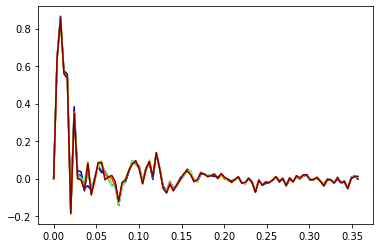

In [40]:
for cycle in fsc_curves.keys():
    plt.plot(freq, radial_phase_profiles[cycle], color=colors[cycle], label=f"Cycle {cycle}")


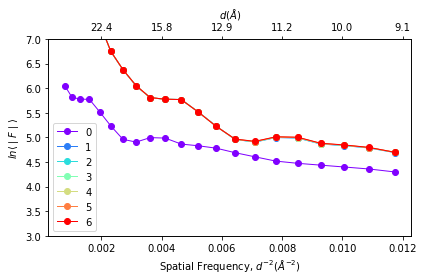

In [41]:
from locscale.include.emmer.ndimage.plots import plot_radial_profile

plot_radial_profile(freq, list(radial_profiles.values()), squared_amplitudes=False, legends=list(radial_profiles.keys()), crop_freq=[40, 9], showPoints=True, ylims=[3,7]);
                    

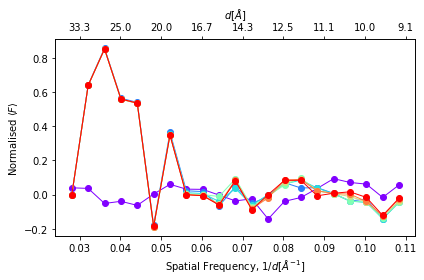

In [42]:
plot_radial_profile(freq, list(radial_phase_profiles.values()), squared_amplitudes=True, legends=list(radial_profiles.keys()), crop_freq=[40, 9], showPoints=True, logScale=False, showlegend=False);
